In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# os.mkdir('Reddit_ML')

In [3]:
os.chdir('Reddit_ML')

In [4]:
# !wget http://files.pushshift.io/reddit/comments/RC_2015-01.bz2

In [5]:
import bz2
import json
import pandas as pd

In [6]:
filename = 'RC_2015-01.bz2'

In [7]:
with bz2.open(filename, "rt") as bzinput:
    lines = []
    for i, line in enumerate(bzinput):
        if i == 200000:
            break
        reddit = json.loads(line)
        lines.append(reddit)

In [8]:
df = pd.DataFrame(lines)

In [9]:
df

,score_hidden,name,link_id,body,downs,created_utc,score,author,distinguished,id,archived,parent_id,subreddit,author_flair_css_class,author_flair_text,gilded,retrieved_on,ups,controversiality,subreddit_id,edited
0,False,t1_cnas8zv,t3_2qyr1a,Most of us have some family members like this....,0,1420070400,14,YoungModern,None,cnas8zv,False,t3_2qyr1a,exmormon,None,None,0,1425124282,14,0,t5_2r0gj,False
1,False,t1_cnas8zw,t3_2qv6c6,But Mill's career was way better. Bentham is l...,0,1420070400,3,RedCoatsForever,None,cnas8zw,False,t1_cnas2b6,CanadaPolitics,on,Ontario,0,1425124282,3,0,t5_2s4gt,False
2,False,t1_cnas8zx,t3_2qxefp,"Mine uses a strait razor, and as much as i lov...",0,1420070400,1,vhisic,None,cnas8zx,False,t3_2qxefp,AdviceAnimals,None,None,0,1425124282,1,0,t5_2s7tt,False
3,False,t1_cnas8zy,t3_2qys4x,[deleted],0,1420070400,1,[deleted],None,cnas8zy,False,t3_2qys4x,AdviceAnimals,None,None,0,1425124282,1,0,t5_2s7tt,False
4,False,t1_cnas8zz,t3_2qm5bi,"Very fast, thank you!",0,1420070400,2,Mastersimpson,None,cnas8zz,False,t3_2qm5bi,freedonuts,None,None,0,1425124282,2,0,t5_2y51u,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,False,t1_cnawl5n,t3_2qons3,"*Nik bent a little, but laughed.* ""Relax... ju...",0,1420080960,1,TotalWarfare,None,cnawl5n,False,t1_cnawk9g,rwbyRP,,Wilhelm Jung | Nikolas Brunoz,0,1425122260,1,0,t5_32s5j,False
199996,False,t1_cnawl5o,t3_2qz61i,I want to get some lotion products from indie....,0,1420080960,2,Asiastana,None,cnawl5o,False,t3_2qz61i,Indiemakeupandmore,None,None,0,1425122260,2,0,t5_2w8pb,False
199997,False,t1_cnawl5p,t3_2qx40m,"Trust me, you are that whole new person. Good...",0,1420080960,4,Kashik,None,cnawl5p,False,t1_cnack45,progresspics,None,None,0,1425122260,4,0,t5_2sl0y,False
199998,False,t1_cnawl5q,t3_2qx0x0,[deleted],0,1420080960,1,[deleted],None,cnawl5q,False,t3_2qx0x0,Cooking,None,None,0,1425122260,1,0,t5_2qh7f,False


In [10]:
print(df.columns.tolist())

['score_hidden', 'name', 'link_id', 'body', 'downs', 'created_utc', 'score', 'author', 'distinguished', 'id', 'archived', 'parent_id', 'subreddit', 'author_flair_css_class', 'author_flair_text', 'gilded', 'retrieved_on', 'ups', 'controversiality', 'subreddit_id', 'edited']


In [11]:
print(df.shape)
df.head().T

(200000, 21)


,0,1,2,3,4
score_hidden,False,False,False,False,False
name,t1_cnas8zv,t1_cnas8zw,t1_cnas8zx,t1_cnas8zy,t1_cnas8zz
link_id,t3_2qyr1a,t3_2qv6c6,t3_2qxefp,t3_2qys4x,t3_2qm5bi
body,Most of us have some family members like this....,But Mill's career was way better. Bentham is l...,"Mine uses a strait razor, and as much as i lov...",[deleted],"Very fast, thank you!"
downs,0,0,0,0,0
created_utc,1420070400,1420070400,1420070400,1420070400,1420070400
score,14,3,1,1,2
author,YoungModern,RedCoatsForever,vhisic,[deleted],Mastersimpson
distinguished,None,None,None,None,None
id,cnas8zv,cnas8zw,cnas8zx,cnas8zy,cnas8zz


In [12]:

import re
import string

import pandas as pd
import feather
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine, euclidean

from pathlib import Path
from collections import Counter
from multiprocessing import Pool
from urllib.parse import urlparse


import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


# **Data Preprocessing**

In [13]:
df = df[df.body != '[deleted]']
df = df[df.body != '[removed]']
df = df[df.body != '']
print(df.shape)

(187222, 21)


In [14]:
df.dropna()

,score_hidden,name,link_id,body,downs,created_utc,score,author,distinguished,id,archived,parent_id,subreddit,author_flair_css_class,author_flair_text,gilded,retrieved_on,ups,controversiality,subreddit_id,edited
466,False,t1_cnas9d9,t3_2obdv6,We're getting brigaded by SRD and SRSSucks\n\n...,0,1420070424,0,Meowsticgoesnya,moderator,cnas9d9,False,t1_cmlrvq6,AgainstGamerGate,,"Fuck #Gamergate, it's horrible.",0,1425124279,0,0,t5_3441a,False
1247,False,t1_cnas9zh,t3_2qy7u9,"Hey,\n\nI've approved the comments for now, bu...",0,1420070463,1,EdenSB,moderator,cnas9zh,False,t1_cnaqs1u,RandomKindness,MOD,MOD | SENT | RECEIVED,0,1425124270,1,0,t5_2szh3,False
1671,False,t1_cnasabk,t3_2qy8e0,Your post has been removed as a repost. Please...,0,1420070485,1,delicious_cheese,moderator,cnasabk,False,t3_2qy8e0,xboxone,xbox-day-one,Delicious Cyan,0,1425124265,1,0,t5_2xbci,False
1837,False,t1_cnasag9,t3_2qy8r7,Your post has been removed as a repost. Please...,0,1420070492,1,delicious_cheese,moderator,cnasag9,False,t3_2qy8r7,xboxone,xbox-day-one,Delicious Cyan,0,1425124264,1,0,t5_2xbci,False
2593,False,t1_cnasb1k,t3_2qy728,Your post has been removed. Please read the ru...,0,1420070532,0,delicious_cheese,moderator,cnasb1k,False,t3_2qy728,xboxone,xbox-day-one,Delicious Cyan,0,1425124256,0,0,t5_2xbci,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197370,False,t1_cnawj3n,t3_2qz4lt,We already have that and those posts are activ...,0,1420080807,13,maybesaydie,moderator,cnawj3n,False,t1_cnawf54,fatlogic,,Tears on my steering wheel,0,1425122285,13,0,t5_2wyxm,False
197580,False,t1_cnawj9j,t3_2qvgwb,The sidebar is worded that way to allow us som...,0,1420080818,2,millionsofcats,moderator,cnawj9j,False,t1_cnaqiyj,linguistics,,Phonetics &amp; Phonology | Language Documenta...,0,1425122283,2,0,t5_2qhos,False
199620,False,t1_cnawkv7,t3_2mf1i0,Interesting. Do you have any ~~proof of you mo...,0,1420080938,1,3vans,moderator,cnawkv7,False,t1_cnawcus,Monstercat,dayone,Day One,0,1425122262,1,0,t5_2se72,1420081125
199650,False,t1_cnawkw1,t3_2qxkfa,The rev post quality content and is an active ...,0,1420080940,0,Gibb1982,moderator,cnawkw1,False,t1_cnahdzr,Saints,state,Mod,0,1425122262,0,0,t5_2s1wf,False


In [15]:
# df.subreddit.value_counts().plot(kind='bar')
# plt.show()

In [16]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.16652627378702228 GB'

In [17]:
df.distinguished.replace(to_replace=[None], value='user', inplace=True)
df.distinguished.replace(to_replace=np.NaN, value='user', inplace=True)

In [18]:
df['subreddit'] = df.subreddit.astype('category')
df['subreddit_id'] = df.subreddit_id.astype('category')
df['distinguished'] = df.distinguished.astype('category')
df['link_id'] = df.link_id.astype('category')

In [19]:
df['distinguished'].dtype

CategoricalDtype(categories=['moderator', 'user'], ordered=False)

In [20]:
# The number of hours between when the comment was posted & when it was scraped
t = (df.retrieved_on - df.created_utc.astype(str).astype(int)) / 60 / 60
t.min()

1400.361111111111

In [21]:
# Remove superfluous explanatory variables
df.drop(['archived', 'retrieved_on', 'id'], axis=1, inplace=True)
print(df.shape)
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

(187222, 18)


'0.12181047026725363 GB'

In [22]:
df.distinguished.replace(to_replace=np.NaN, value='user', inplace=True)

In [23]:
df['time'] = pd.to_datetime(df.created_utc, unit='s')

In [24]:
# Find the time of the first comment in a thread
df_first_comment = df[['link_id', 'time']].groupby(by=['link_id']).min()

# Create a dictionary of {link_id -> timestamp} pairs
df_first_comment_dict = df_first_comment.to_dict('index')

# Funct that takes in {link_id, timestamp} pair & returns the time elapsed since the first comment in that link_id.
def time_lapse(x):
    return df_first_comment_dict[x]['time']

# Add a column of the time_elapsed from the first comment in a link_id
df['time_lapse'] = df.time - df.link_id.apply(time_lapse)

# Convert the type of time_lapse back to seconds
df.time_lapse = df.time_lapse.apply(lambda x: x.total_seconds())

df['hour_of_comment'] = df.time.apply(lambda x: x.hour)
df['weekday'] = df.time.dt.weekday

In [25]:
# Total comments / unique threads 
len(df.link_id) / len(df.link_id.unique())

4.4302413629910085

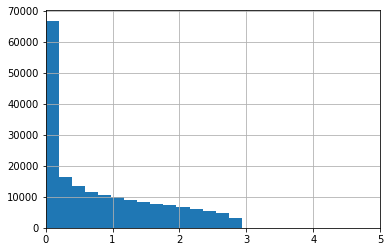

In [26]:
# hours after first comment in thread
(df.time_lapse / (60*60)).hist(bins=15).set_xlim((0, 5));

In [27]:
df['is_flair'] = ~df.author_flair_text.apply(lambda x: x is None)
df['is_flair_css'] = ~df.author_flair_css_class.apply(lambda x: x is None)

print(sum(df.is_flair) / len(df.is_flair))
print(sum(df.is_flair_css) / len(df.is_flair_css))
0.007156374534157479

0.3968123404300777
0.39421115039899157


0.007156374534157479

In [28]:
def pd_to_dict(df, index='', column=''):
    return pd.Series(df[column].values, index=df[index]).to_dict()

comment_to_parent_dict = pd_to_dict(df[['name', 'parent_id']],
                                    index='name', column='parent_id')

def get_depth(x):
    counter = 0
    temp = x
    while True:
        if temp[:3] == 't3_':
            return counter
        try:
            temp = comment_to_parent_dict[temp]
        except KeyError:
            return counter
        counter += 1
        
df['depth'] = df['name'].apply(get_depth)
comment_to_score = pd_to_dict(df[['name', 'score']],
                              index='name', column='score')

def get_parent_score(x):
    try:
        return comment_to_score[x]
    except:
        return np.nan

df['parent_score'] = df.parent_id.apply(lambda x: get_parent_score(x))
# imp_val = df.parent_score.median()
# df.parent_score.fillna(imp_val, inplace=True)

comment_to_time = pd_to_dict(df[['name', 'time']],
                              index='name', column='time')

def get_time_since_parent(pi):
    try:
        return comment_to_time[pi]
    except:
        return np.nan

df['time_since_parent'] = df.parent_id.apply(get_time_since_parent)
df.loc[df.time_since_parent.isna(), 'time_since_parent'] = df.time
df.time_since_parent = df.time - df.time_since_parent
df.time_since_parent = df.time_since_parent.apply(lambda x: x.total_seconds())

In [29]:
sum(df.parent_score != df.parent_score) / len(df.parent_score)

0.6984008289624083

In [30]:
df.head().T

,0,1,2,4,5
score_hidden,False,False,False,False,False
name,t1_cnas8zv,t1_cnas8zw,t1_cnas8zx,t1_cnas8zz,t1_cnas900
link_id,t3_2qyr1a,t3_2qv6c6,t3_2qxefp,t3_2qm5bi,t3_2qxe1p
body,Most of us have some family members like this....,But Mill's career was way better. Bentham is l...,"Mine uses a strait razor, and as much as i lov...","Very fast, thank you!","The guy is a professional, and very good at wh..."
downs,0,0,0,0,0
created_utc,1420070400,1420070400,1420070400,1420070400,1420070400
score,14,3,1,2,6
author,YoungModern,RedCoatsForever,vhisic,Mastersimpson,BigGupp1
distinguished,user,user,user,user,user
parent_id,t3_2qyr1a,t1_cnas2b6,t3_2qxefp,t3_2qm5bi,t1_cnaqg2t


In [31]:
def get_comment_tree_root(x):
    if comment_to_parent_dict[x][:3] == 't3_':
        return x
    try:
        return get_comment_tree_root(comment_to_parent_dict[x])
    except KeyError:
        return np.nan
    
comment_to_time = pd_to_dict(df[['name', 'time']],
                              index='name', column='time')

def get_time(x):
    try:
        return comment_to_time[x]
    except:
        return np.nan
    
df['comment_tree_root_id'] = df.name.apply(get_comment_tree_root)
df['comment_tree_root_score'] = df.comment_tree_root_id.apply(lambda x: get_parent_score(x))
df['time_since_comment_tree_root'] = df.time - df.comment_tree_root_id.apply(get_time)
df.time_since_comment_tree_root = df.time_since_comment_tree_root.apply(lambda x: x.total_seconds())

In [32]:
print(sum(df.comment_tree_root_id == df.name) / len(df.depth))

0.40289068592366284


In [33]:
# Extract an array of subreddit links in a post & use as a feature
df['linked_sr'] = df.body.apply(lambda x: re.findall(r"/r/([^\s/]+)", x))

# Remove the subreddits mentioned from the actual comment
df['body'] = df.body.apply(lambda x: re.sub(r"(/r/[^\s/]+)", '', x))

In [34]:
# Nasty Regular Extraction to extract a link
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def get_domains(x):
    """
    Given a comment (String), extract an array of urls' domain names mentioned in the comment
    """
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    urls = re.findall(url_regex, x)
    try:
        domain_names = [urlparse(url).netloc.split('.')[-2] for url in urls]
    except:
        return []
    return domain_names

# Create the feature for each observation
df['linked_urls'] = df.body.apply(lambda x: get_domains(x))

In [35]:
def remove_urls(x):
    """
    Given a comment, replace the url component with an empty string. 
    """
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    return re.sub(url_regex, '', x)

# Remove the URL from each comment 
df['body'] = df.body.apply(lambda x: remove_urls(x))

In [36]:
# Create a how-many-subreddit-links-were-in-this-comment? feature
df['no_of_linked_sr'] = df['linked_sr'].apply(lambda x: len(x))

# Create a how-many-urls-were-in-this-comment? feature
df['no_of_linked_urls'] = df['linked_urls'].apply(lambda x: len(x))

In [37]:
print(f"Subreddit-links-per-post  {sum(df.no_of_linked_sr) / len(df.body)}")
print(f"URL-links-per-post        {sum(df.no_of_linked_urls) / len(df.body)}")

Subreddit-links-per-post  0.03968016579248165
URL-links-per-post        0.09859418230763478


In [38]:
all_linked_sr = []
for l in df.linked_sr.values:
    all_linked_sr += l

top_sr_links = Counter(all_linked_sr)
top_sr_links.most_common(15)

[('AutoModerator', 991),
 ('autowikibot', 237),
 ('havoc_bot', 188),
 ('AskReddit', 185),
 ('Jokes', 120),
 ('trees', 120),
 ('mildlyinteresting', 107),
 ('havoc_bot)', 94),
 ('videos', 90),
 ('AskScienceFiction', 85),
 ('WritingPrompts', 84),
 ('Fitness', 83),
 ('kpop', 78),
 ('HFY', 63),
 ('GlobalOffensiveTrade', 56)]

In [39]:
all_linked_urls = []
for l in df.linked_urls.values:
    all_linked_urls += l

top_url_links = Counter(all_linked_urls)
top_url_links.most_common(15)

[('reddit', 3564),
 ('imgur', 2372),
 ('wikipedia', 1672),
 ('youtube', 1420),
 ('tumblr', 954),
 ('pcpartpicker', 495),
 ('google', 297),
 ('youtu', 285),
 ('twitter', 227),
 ('redd', 227),
 ('github', 218),
 ('steamcommunity', 185),
 ('wizards', 183),
 ('amazon', 160),
 ('co', 121)]

In [40]:
# Find the most common URLs
allowed_urls = [i[0] for i in top_url_links.most_common(15)]

def remove_urls(x):
    """
    Given a list of URLs, keep only those in the top-15. 
    """
    y = []
    for i in x:
        if i in allowed_urls:
            y += [i]
    return y

# Keep only the popular URLs 
df['linked_urls'] = df['linked_urls'].apply(lambda x: remove_urls(x))

In [41]:
# Implement the above
df['subjectivity'] = df['body'].str.count('I ')

In [42]:
# Create a column indicating if the comment is edited or not
df['is_edited'] = df.edited.apply(lambda x: x > 0)

In [43]:
f"Edited/All = {sum(df.is_edited) / len(df.is_edited)}"

'Edited/All = 0.02497569730053092'

In [44]:
# if the comment quotes another comment, indicate that with a boolean
df['is_quoted'] = df.body.str.contains('&gt;')

In [45]:
# Implement the above
df['no_quoted'] = df.body.str.count('&gt;')

In [46]:
df.head(3).T

,0,1,2
score_hidden,False,False,False
name,t1_cnas8zv,t1_cnas8zw,t1_cnas8zx
link_id,t3_2qyr1a,t3_2qv6c6,t3_2qxefp
body,Most of us have some family members like this....,But Mill's career was way better. Bentham is l...,"Mine uses a strait razor, and as much as i lov..."
downs,0,0,0
created_utc,1420070400,1420070400,1420070400
score,14,3,1
author,YoungModern,RedCoatsForever,vhisic
distinguished,user,user,user
parent_id,t3_2qyr1a,t1_cnas2b6,t3_2qxefp


In [47]:
print(f"Subreddit-links-per-post  {sum(df.no_of_linked_sr) / len(df.body)}")
print(f"URL-links-per-post        {sum(df.no_of_linked_urls) / len(df.body)}")

Subreddit-links-per-post  0.03968016579248165
URL-links-per-post        0.09859418230763478


In [48]:
f"Edited/All = {sum(df.is_edited) / len(df.is_edited)}"

'Edited/All = 0.02497569730053092'

In [49]:
top_sr_links.most_common(15)

[('AutoModerator', 991),
 ('autowikibot', 237),
 ('havoc_bot', 188),
 ('AskReddit', 185),
 ('Jokes', 120),
 ('trees', 120),
 ('mildlyinteresting', 107),
 ('havoc_bot)', 94),
 ('videos', 90),
 ('AskScienceFiction', 85),
 ('WritingPrompts', 84),
 ('Fitness', 83),
 ('kpop', 78),
 ('HFY', 63),
 ('GlobalOffensiveTrade', 56)]

In [50]:
top_url_links.most_common(15)

[('reddit', 3564),
 ('imgur', 2372),
 ('wikipedia', 1672),
 ('youtube', 1420),
 ('tumblr', 954),
 ('pcpartpicker', 495),
 ('google', 297),
 ('youtu', 285),
 ('twitter', 227),
 ('redd', 227),
 ('github', 218),
 ('steamcommunity', 185),
 ('wizards', 183),
 ('amazon', 160),
 ('co', 121)]

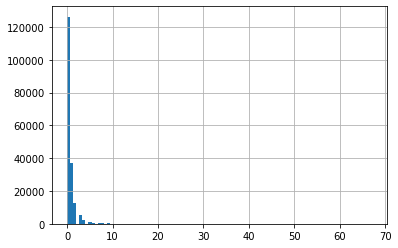

In [51]:
df.subjectivity.hist(bins=100)
plt.show()

In [52]:
df.head().T

,0,1,2,4,5
score_hidden,False,False,False,False,False
name,t1_cnas8zv,t1_cnas8zw,t1_cnas8zx,t1_cnas8zz,t1_cnas900
link_id,t3_2qyr1a,t3_2qv6c6,t3_2qxefp,t3_2qm5bi,t3_2qxe1p
body,Most of us have some family members like this....,But Mill's career was way better. Bentham is l...,"Mine uses a strait razor, and as much as i lov...","Very fast, thank you!","The guy is a professional, and very good at wh..."
downs,0,0,0,0,0
created_utc,1420070400,1420070400,1420070400,1420070400,1420070400
score,14,3,1,2,6
author,YoungModern,RedCoatsForever,vhisic,Mastersimpson,BigGupp1
distinguished,user,user,user,user,user
parent_id,t3_2qyr1a,t1_cnas2b6,t3_2qxefp,t3_2qm5bi,t1_cnaqg2t


In [53]:
 !pip install vaderSentiment

In [54]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# sentiment analyzer
analyser = SentimentIntensityAnalyzer() # http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html

# get sentiment scores 
def get_sentiment(x):
    return analyser.polarity_scores(x)

# get sentiment scores from 'body' column of dataframe
def wrapper_get_sentiment(df):
    df['sentiment'] = df['body'].apply(get_sentiment)
    return df

# to apply operation in parallel
num_partitions = 100
num_cores = 4
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# add a column for each score to our data
sentiment = parallelize_dataframe(df['body'].to_frame(), wrapper_get_sentiment)
sentiment.drop(['body'], axis=1, inplace=True)
df['senti_neg'] = sentiment['sentiment'].apply(lambda x: x['neg'])
df['senti_neu'] = sentiment['sentiment'].apply(lambda x: x['neu'])
df['senti_pos'] = sentiment['sentiment'].apply(lambda x: x['pos'])
df['senti_comp'] = sentiment['sentiment'].apply(lambda x: x['compound'])
del sentiment

In [55]:
print(df.shape)
df.head().T

(187222, 42)


,0,1,2,4,5
score_hidden,False,False,False,False,False
name,t1_cnas8zv,t1_cnas8zw,t1_cnas8zx,t1_cnas8zz,t1_cnas900
link_id,t3_2qyr1a,t3_2qv6c6,t3_2qxefp,t3_2qm5bi,t3_2qxe1p
body,Most of us have some family members like this....,But Mill's career was way better. Bentham is l...,"Mine uses a strait razor, and as much as i lov...","Very fast, thank you!","The guy is a professional, and very good at wh..."
downs,0,0,0,0,0
created_utc,1420070400,1420070400,1420070400,1420070400,1420070400
score,14,3,1,2,6
author,YoungModern,RedCoatsForever,vhisic,Mastersimpson,BigGupp1
distinguished,user,user,user,user,user
parent_id,t3_2qyr1a,t1_cnas2b6,t3_2qxefp,t3_2qm5bi,t1_cnaqg2t


In [56]:
# save sentiment data
# df.to_pickle('Data/sentiment.pkl')

In [57]:
# get number of words in comment
def get_word_count(df):
    df['word_count'] = df['body'].apply(lambda x: len(x.split()))
    return df

word_counts = parallelize_dataframe(df['body'].to_frame(), get_word_count)
df['word_counts'] = word_counts.word_count
del word_counts

In [58]:
print(df.shape)
df.head().T

(187222, 43)


,0,1,2,4,5
score_hidden,False,False,False,False,False
name,t1_cnas8zv,t1_cnas8zw,t1_cnas8zx,t1_cnas8zz,t1_cnas900
link_id,t3_2qyr1a,t3_2qv6c6,t3_2qxefp,t3_2qm5bi,t3_2qxe1p
body,Most of us have some family members like this....,But Mill's career was way better. Bentham is l...,"Mine uses a strait razor, and as much as i lov...","Very fast, thank you!","The guy is a professional, and very good at wh..."
downs,0,0,0,0,0
created_utc,1420070400,1420070400,1420070400,1420070400,1420070400
score,14,3,1,2,6
author,YoungModern,RedCoatsForever,vhisic,Mastersimpson,BigGupp1
distinguished,user,user,user,user,user
parent_id,t3_2qyr1a,t1_cnas2b6,t3_2qxefp,t3_2qm5bi,t1_cnaqg2t


In [59]:
print(f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB")

0.17875443854142284 GB


In [60]:
# save new data
df.to_csv('working_dataset_v1.csv')

# **Add thread level data**
# **Original Features**
# **Engineer new features**
# **ans LAST 2**
### are LEFT

In [61]:
processed_data = pd.read_csv('working_dataset_v1.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18,19,20,23,24,26,27,28,31,32,33,36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [62]:
scraped_data = pd.read_csv('ScrapedDF_final.csv')

In [63]:

scraped_data.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
sub_id,t3_2qyr1a,t3_2qxefp,t3_2qm5bi,t3_2qxlvm,t3_2qy7at
created_utc,1.42007e+09,1.42004e+09,1.41977e+09,NaN,1.42006e+09
distinguished,NaN,NaN,NaN,NaN,NaN
edited,False,False,1420315336.0,NaN,False
locked,False,False,False,NaN,False
url,https://www.reddit.com/r/exmormon/comments/2qy...,https://imgur.com/3e8DBss,https://www.reddit.com/r/freedonuts/comments/2...,NaN,http://i.imgur.com/iFyrpSE.jpg
num_comments,24.0,64.0,42.0,NaN,2.0
over_18,False,False,False,NaN,False
score,35,1398,10,NaN,0


In [64]:
del scraped_data['Unnamed: 0']

In [65]:
del scraped_data['Unnamed: 0.1']

In [66]:
scraped_data.shape

(29257, 18)

In [67]:
scraped_data['url'] = scraped_data.url.astype('category')
scraped_data['selftext'] = scraped_data.selftext.astype('category')
scraped_data['title'] = scraped_data.title.astype('category')

In [68]:
scraped_data['link_created_time'] = pd.to_datetime(scraped_data.created_utc, unit='s')

In [69]:
scraped_data.drop(['locked', 'downs', 'is_original_content',
          'view_count', 'distinguished', 'edited',
          'num_crossposts', 'spoiler', 'created_utc'], axis=1, inplace=True)

In [70]:
scraped_data.rename(columns={'sub_id':'link_id', 
                    'ups': 'link_ups',
                    'score': 'link_score'}, inplace=True)

In [71]:
scraped_data.tail().T

,29252,29253,29254,29255,29256
link_id,t3_2q7z0z,t3_2qy3ii,t3_2qz27d,t3_2qy433,t3_2qz29h
url,http://youtu.be/rRaNLeqBp2Q,https://www.reddit.com/r/personalfinance/comme...,http://www.bilder.beofnf.de/gifs/uhmm.gif,https://www.reddit.com/r/Frozen/comments/2qy43...,https://www.reddit.com/r/FancyFollicles/commen...
num_comments,19.0,15.0,8.0,1.0,6.0
over_18,False,False,False,False,False
link_score,100,12,2,6,1
selftext,NaN,Hi PF! Long time lurker and first time poster!...,[deleted],NaN,"I've been through a few different colors, but ..."
title,Good Samaritan shields woman and baby from Vio...,Advice: Credit score length of time vs. high u...,I've been hooking up with my best friend who c...,gray scale anna by Daleksyouruncle on DeviantArt,White hair for probably the fifth time. sugges...
upvote_ratio,0.84,0.73,0.57,1,0.67
link_ups,100,12,2,6,1
link_created_time,2014-12-23 22:54:51,2014-12-31 19:56:17,2015-01-01 01:52:51,2014-12-31 20:01:19,2015-01-01 01:53:37


In [72]:
f"{scraped_data.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.024608402296655254 GB'

In [73]:
df = processed_data.merge(scraped_data, on='link_id', how='left')

In [74]:
df.dropna()

,Unnamed: 0,score_hidden,name,link_id,body,downs,created_utc,score,author,distinguished,parent_id,subreddit,author_flair_css_class,author_flair_text,gilded,ups,controversiality,subreddit_id,edited,time,time_lapse,hour_of_comment,weekday,is_flair,is_flair_css,depth,parent_score,time_since_parent,comment_tree_root_id,comment_tree_root_score,time_since_comment_tree_root,linked_sr,linked_urls,no_of_linked_sr,no_of_linked_urls,subjectivity,is_edited,is_quoted,no_quoted,senti_neg,senti_neu,senti_pos,senti_comp,word_counts,url,num_comments,over_18,link_score,selftext,title,upvote_ratio,link_ups,link_created_time
902,963,False,t1_cnas9rd,t3_2prgfu,WHO IS GILBERT?,0,1420070449,3,TurtleforAG,user,t1_cnas95x,Omnipotent_League,slowbromegashinyf,Self-Proclaimed FFA Master,0,3,0.0,t5_35h4f,False,2015-01-01 00:00:49,43.0,0.0,3.0,True,True,2.0,3,38.0,t1_cnas95x,3.0,38.0,[],[],0,0.0,0.0,False,False,0.0,0.000,1.000,0.000,0.0000,3.0,https://www.reddit.com/r/Omnipotent_League/com...,23545.0,False,12.0,[deleted],Chat post!,0.69,12.0,2014-12-19 05:38:38
1921,2043,False,t1_cnasam3,t3_2qy42q,Are you serious right now?,0,1420070503,4,MouSe05,user,t1_cnas9mt,CFB,missouri-sheet1-row06-col09-missouristate-2sht...,Missouri Tigers / Missouri State Bears,0,4,0.0,t5_2qm9d,False,2015-01-01 00:01:43,89.0,0.0,3.0,True,True,2.0,-3,62.0,t1_cnas9mt,-3.0,62.0,[],[],0,0.0,0.0,False,False,0.0,0.245,0.755,0.000,-0.0772,5.0,https://www.reddit.com/r/CFB/comments/2qy42q/g...,4405.0,False,274.0,### [](#f/boisestate) #19 Boise State Broncos ...,[Game Thread] Fiesta Bowl: Boise State vs Ariz...,0.93,274.0,2014-12-31 20:01:14
2121,2252,False,t1_cnasary,t3_2qyktv,"Dude, you're gonna get your birthday ganked!",0,1420070515,2,IntoTheStratosphere,user,t1_cnas9st,hockey,FLANHL,FLANHL,0,2,0.0,t5_2qiel,False,2015-01-01 00:01:55,109.0,0.0,3.0,True,True,2.0,-3,63.0,t1_cnas9st,-3.0,63.0,[],[],0,0.0,0.0,False,False,0.0,0.000,1.000,0.000,0.0000,7.0,https://www.reddit.com/r/hockey/comments/2qykt...,526.0,False,39.0,#### Scoring Summary\n\n| Period | [](/r/flori...,Game Thread: New York Rangers (19-11-4) @ Flor...,0.92,39.0,2014-12-31 22:43:33
2373,2523,False,t1_cnasazl,t3_2qykl8,"Paq looks tired, not used to the grind. Really...",0,1420070529,3,MoreWeight,user,t1_cnasaih,hockey,TBLNHL,TBLNHL,0,3,0.0,t5_2qiel,False,2015-01-01 00:02:09,90.0,0.0,3.0,True,True,2.0,1,33.0,t1_cnasaih,1.0,33.0,[],[],0,0.0,0.0,False,False,0.0,0.182,0.818,0.000,-0.4404,14.0,https://www.reddit.com/r/hockey/comments/2qykl...,333.0,False,28.0,|GAME DAY: Wednesday 12/31/2014|\n|:--:|\n|Fir...,Game Thread: Lightning at Sabres - 12/31/2014 ...,0.90,28.0,2014-12-31 22:41:12
2529,2694,False,t1_cnasb4e,t3_2qykl8,Welcome!,0,1420070538,1,MoreWeight,user,t1_cnasa2u,hockey,TBLNHL,TBLNHL,0,1,0.0,t5_2qiel,False,2015-01-01 00:02:18,99.0,0.0,3.0,True,True,2.0,2,69.0,t1_cnasa2u,2.0,69.0,[],[],0,0.0,0.0,False,False,0.0,0.000,0.000,1.000,0.5093,1.0,https://www.reddit.com/r/hockey/comments/2qykl...,333.0,False,28.0,|GAME DAY: Wednesday 12/31/2014|\n|:--:|\n|Fir...,Game Thread: Lightning at Sabres - 12/31/2014 ...,0.90,28.0,2014-12-31 22:41:12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220084,199957,False,t1_cnawl4k,t3_2qxymh,o.o\n\n\nInteresting.,0,1420080958,1,Markofdawn,user,t1_cnat5x3,asktransgender,trans-queer,MtF 17 year old. Not much else.,0,1,0.0,t5_2r4b9,False,2015-01-01 02:55:58,10521,2.0,3.0,True,True,2.0,5,8500,t1_cnat5x3,5.0,8500.0,[],[],0,0.0,0.0,False,False,0.0,0.400,0.000,0.600,0.2263,2.0,https://www.reddit.com/r/asktransgender/commen...,209.0,False,43.0,"In light of recent events and posts, I thought...",Tell us about yourself!,0.94,43.0,2014-12-31 19:11:31
220097,199970,False,t1_cnawl4x,t3_2qz074,OOC: Im pulling a Peeta and hes basically brai...,0,1420080959,1,iWhovian,user,t1_cnaw2tw,PercyJacksonRP,lightpurplebg white,Child of Victoria,0,1,0.0,t5

In [75]:
df.time.replace(to_replace=[None], value='2015-05-01 00:02:36', inplace=True)
df.time.replace(to_replace=np.NaN, value='2015-05-01 00:02:36', inplace=True)
df.time.replace(to_replace='False', value='2015-05-01 00:02:36', inplace=True)
df.time.replace(to_replace='True', value='2015-05-01 00:02:36', inplace=True)

In [76]:
df.isna().sum()

Unnamed: 0                           9
score_hidden                     23433
name                             23433
link_id                          23433
body                             24336
downs                            32902
created_utc                      32902
score                            32904
author                           32938
distinguished                    32937
parent_id                        32902
subreddit                        32902
author_flair_css_class          156454
author_flair_text               160429
gilded                           32902
ups                              32902
controversiality                 32902
subreddit_id                     32902
edited                           32902
time                                 0
time_lapse                       32902
hour_of_comment                  32904
weekday                          32941
is_flair                         32905
is_flair_css                     32934
depth                    

In [77]:
df['time'] =  pd.to_datetime(df['time'],format='%Y-%m-%d %H:%M:%S.%f' ) 
df['link_created_time'] =  pd.to_datetime(df['link_created_time'],format='%Y-%m-%d %H:%M:%S.%f' ) #2015-05-01 00:02:36

In [78]:
df['time_since_link'] = (df.time.subtract(df.link_created_time))
df.time_since_link = [x.total_seconds() for x in df.time_since_link]

In [79]:
df.shape

(220124, 54)

In [80]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.43672374536790576 GB'

In [81]:
df.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,4,5
score_hidden,False,False,False,False,False
name,t1_cnas8zv,t1_cnas8zw,t1_cnas8zx,t1_cnas8zz,t1_cnas900
link_id,t3_2qyr1a,t3_2qv6c6,t3_2qxefp,t3_2qm5bi,t3_2qxe1p
body,Most of us have some family members like this....,But Mill's career was way better. Bentham is l...,"Mine uses a strait razor, and as much as i lov...","Very fast, thank you!","The guy is a professional, and very good at wh..."
downs,0,0,0,0,0
created_utc,1420070400,1420070400,1420070400,1420070400,1420070400
score,14,3,1,2,6
author,YoungModern,RedCoatsForever,vhisic,Mastersimpson,BigGupp1
distinguished,user,user,user,user,user


In [82]:
# drops about 2000 rows due to link_id not in scraped_data
df = df.iloc[np.where(df.title == df.title)]
print(df.shape)
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

(160117, 54)


'0.3424371055950952 GB'

In [83]:
df.comment_tree_root_score.replace(to_replace=[None], value='0', inplace=True)
df.comment_tree_root_score.replace(to_replace=np.NaN, value='0', inplace=True)

In [84]:
df['url'] = df.url.astype('str').apply(lambda x: urlparse(x)[1])
df['url'] = df.url.astype('category')
df['is_root'] = df.parent_id.str.startswith('t3_', na=False)
df.loc[df.is_root, 'comment_tree_root_score'] = np.nan # if comment is a root, comment_tree_root_score is the same as score. Can't have this
df['is_selftext'] = df.selftext.str.len() > 1

In [85]:
print(df.shape)
print(f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB")
df.head().T

(160117, 56)
0.34358718962089385 GB


,0,2,3,4,7
Unnamed: 0,0,2,4,5,8
score_hidden,False,False,False,False,False
name,t1_cnas8zv,t1_cnas8zx,t1_cnas8zz,t1_cnas900,t1_cnas903
link_id,t3_2qyr1a,t3_2qxefp,t3_2qm5bi,t3_2qxe1p,t3_2qyizj
body,Most of us have some family members like this....,"Mine uses a strait razor, and as much as i lov...","Very fast, thank you!","The guy is a professional, and very good at wh...",:D.
downs,0,0,0,0,0
created_utc,1420070400,1420070400,1420070400,1420070400,1420070400
score,14,1,2,6,1
author,YoungModern,vhisic,Mastersimpson,BigGupp1,slicked9778
distinguished,user,user,user,user,user


In [86]:
df.dropna()

,Unnamed: 0,score_hidden,name,link_id,body,downs,created_utc,score,author,distinguished,parent_id,subreddit,author_flair_css_class,author_flair_text,gilded,ups,controversiality,subreddit_id,edited,time,time_lapse,hour_of_comment,weekday,is_flair,is_flair_css,depth,parent_score,time_since_parent,comment_tree_root_id,comment_tree_root_score,time_since_comment_tree_root,linked_sr,linked_urls,no_of_linked_sr,no_of_linked_urls,subjectivity,is_edited,is_quoted,no_quoted,senti_neg,senti_neu,senti_pos,senti_comp,word_counts,url,num_comments,over_18,link_score,selftext,title,upvote_ratio,link_ups,link_created_time,time_since_link,is_root,is_selftext
902,963,False,t1_cnas9rd,t3_2prgfu,WHO IS GILBERT?,0,1420070449,3,TurtleforAG,user,t1_cnas95x,Omnipotent_League,slowbromegashinyf,Self-Proclaimed FFA Master,0,3,0.0,t5_35h4f,False,2015-01-01 00:00:49,43.0,0.0,3.0,True,True,2.0,3,38.0,t1_cnas95x,3,38.0,[],[],0,0.0,0.0,False,False,0.0,0.000,1.000,0.000,0.0000,3.0,www.reddit.com,23545.0,False,12.0,[deleted],Chat post!,0.69,12.0,2014-12-19 05:38:38,1102931.0,False,True
1921,2043,False,t1_cnasam3,t3_2qy42q,Are you serious right now?,0,1420070503,4,MouSe05,user,t1_cnas9mt,CFB,missouri-sheet1-row06-col09-missouristate-2sht...,Missouri Tigers / Missouri State Bears,0,4,0.0,t5_2qm9d,False,2015-01-01 00:01:43,89.0,0.0,3.0,True,True,2.0,-3,62.0,t1_cnas9mt,-3,62.0,[],[],0,0.0,0.0,False,False,0.0,0.245,0.755,0.000,-0.0772,5.0,www.reddit.com,4405.0,False,274.0,### [](#f/boisestate) #19 Boise State Broncos ...,[Game Thread] Fiesta Bowl: Boise State vs Ariz...,0.93,274.0,2014-12-31 20:01:14,14429.0,False,True
2121,2252,False,t1_cnasary,t3_2qyktv,"Dude, you're gonna get your birthday ganked!",0,1420070515,2,IntoTheStratosphere,user,t1_cnas9st,hockey,FLANHL,FLANHL,0,2,0.0,t5_2qiel,False,2015-01-01 00:01:55,109.0,0.0,3.0,True,True,2.0,-3,63.0,t1_cnas9st,-3,63.0,[],[],0,0.0,0.0,False,False,0.0,0.000,1.000,0.000,0.0000,7.0,www.reddit.com,526.0,False,39.0,#### Scoring Summary\n\n| Period | [](/r/flori...,Game Thread: New York Rangers (19-11-4) @ Flor...,0.92,39.0,2014-12-31 22:43:33,4702.0,False,True
2373,2523,False,t1_cnasazl,t3_2qykl8,"Paq looks tired, not used to the grind. Really...",0,1420070529,3,MoreWeight,user,t1_cnasaih,hockey,TBLNHL,TBLNHL,0,3,0.0,t5_2qiel,False,2015-01-01 00:02:09,90.0,0.0,3.0,True,True,2.0,1,33.0,t1_cnasaih,1,33.0,[],[],0,0.0,0.0,False,False,0.0,0.182,0.818,0.000,-0.4404,14.0,www.reddit.com,333.0,False,28.0,|GAME DAY: Wednesday 12/31/2014|\n|:--:|\n|Fir...,Game Thread: Lightning at Sabres - 12/31/2014 ...,0.90,28.0,2014-12-31 22:41:12,4857.0,False,True
2529,2694,False,t1_cnasb4e,t3_2qykl8,Welcome!,0,1420070538,1,MoreWeight,user,t1_cnasa2u,hockey,TBLNHL,TBLNHL,0,1,0.0,t5_2qiel,False,2015-01-01 00:02:18,99.0,0.0,3.0,True,True,2.0,2,69.0,t1_cnasa2u,2,69.0,[],[],0,0.0,0.0,False,False,0.0,0.000,0.000,1.000,0.5093,1.0,www.reddit.com,333.0,False,28.0,|GAME DAY: Wednesday 12/31/2014|\n|:--:|\n|Fir...,Game Thread: Lightning at Sabres - 12/31/2014 ...,0.90,28.0,2014-12-31 22:41:12,4866.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220084,199957,False,t1_cnawl4k,t3_2qxymh,o.o\n\n\nInteresting.,0,1420080958,1,Markofdawn,user,t1_cnat5x3,asktransgender,trans-queer,MtF 17 year old. Not much else.,0,1,0.0,t5_2r4b9,False,2015-01-01 02:55:58,10521,2.0,3.0,True,True,2.0,5,8500,t1_cnat5x3,5,8500.0,[],[],0,0.0,0.0,False,False,0.0,0.400,0.000,0.600,0.2263,2.0,www.reddit.com,209.0,False,43.0,"In light of recent events and posts, I thought...",Tell us about yourself!,0.94,43.0,2014-12-31 19:11:31,27867.0,False,True
220097,199970,False,t1_cnawl4x,t3_2qz074,OOC: Im pulling a Peeta and hes basically brai...,0,1420080959,1,iWhovian,user,t1_cnaw2tw,PercyJacksonRP,lightpurplebg white,Child of Victoria,0,1,0.0,t5_2wwqg,False,2015-01-01 02:55:59,5125,2.0,3.0,True,True,14.0,

# Model Fitting

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

In [89]:
def model_diagnostics(model, pr=True):
    """
    Returns and prints the R-squared, RMSE and the MAE for a trained model
    """
    y_predicted = model.predict(X_test)
    r2 = r2_score(y_test, y_predicted)
    mse = mean_squared_error(y_test, y_predicted)
    mae = mean_absolute_error(y_test, y_predicted)
    if pr:
        print(f"R-Sq: {r2:.4}")
        print(f"RMSE: {np.sqrt(mse)}")
        print(f"MAE: {mae}")
    
    return [r2,np.sqrt(mse),mae]
def plot_residuals(y_test, y_predicted):
    """"
    Plots the distribution for actual and predicted values of the target variable. Also plots the distribution for the residuals
    """
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True)
    sns.distplot(y_test, ax=ax0, kde = False)
    ax0.set(xlabel='Test scores')
    sns.distplot(y_predicted, ax=ax1, kde = False)
    ax1.set(xlabel="Predicted scores")
    plt.show()
    fig, ax2 = plt.subplots()
    sns.distplot((y_test-y_predicted), ax = ax2,kde = False)
    ax2.set(xlabel="Residuals")
    plt.show()
def y_test_vs_y_predicted(y_test,y_predicted):
    """
    Produces a scatter plot for the actual and predicted values of the target variable
    """
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_predicted)
    ax.set_xlabel("Test Scores")
    ax.set_ylim([-75, 1400])
    ax.set_ylabel("Predicted Scores")
    plt.show()
def get_feature_importance(model):
    """
    For fitted tree based models, get_feature_importance can be used to get the feature importance as a tidy output
    """
    X_non_text = pd.get_dummies(df[cat_cols])
    features = numeric_cols + bool_cols + list(X_non_text.columns)
    feature_importance = dict(zip(features, model.feature_importances_))
    for name, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
        print(f"{name:<30}: {importance:>6.2%}")
        print(f"\nTotal importance: {sum(feature_importance.values()):.2%}")
    return feature_importance

In [90]:
parent_scrore_impute = df.parent_score.mode()[0] # impute with mode of parent_score column
comment_tree_root_score_impute = df.comment_tree_root_score.mode()[0] # impute with mode of comment_tree_root_score column
time_since_comment_tree_root_impute = df.time_since_comment_tree_root.mode()[0] # impute with mode of time_since_comment_tree_root column
parent_cosine_impute = 0
parent_euc_impute = 0
df.loc[df.parent_score.isna(), 'parent_score'] = parent_scrore_impute
df.loc[df.comment_tree_root_score.isna(), 'comment_tree_root_score'] = comment_tree_root_score_impute
df.loc[df.time_since_comment_tree_root.isna(), 'time_since_comment_tree_root'] = time_since_comment_tree_root_impute

In [91]:
# df = df.replace(np.nan, 0)
# df = df.astype({"is_flair":'category', "is_flair_css":'category',"hour_of_comment":'category',"weekday":'category'}) 
# df['distinguished'] = df['distinguished'].fillna(0)

In [92]:
df.dropna(subset = ["body"], inplace=True)

In [93]:
df.dropna(subset = ["selftext"], inplace=True)

In [94]:
df.dropna(subset = ["word_counts"], inplace=True)

In [95]:
df.shape

(95848, 56)

In [96]:
df.isna().sum()

Unnamed: 0                          0
score_hidden                        0
name                                0
link_id                             0
body                                0
downs                               0
created_utc                         0
score                               0
author                              0
distinguished                       0
parent_id                           0
subreddit                           0
author_flair_css_class          54377
author_flair_text               57311
gilded                              0
ups                                 0
controversiality                    0
subreddit_id                        0
edited                              0
time                                0
time_lapse                          0
hour_of_comment                     0
weekday                             0
is_flair                            0
is_flair_css                        0
depth                               0
parent_score

In [97]:
# df.to_csv('test.csv')

In [98]:
 df = df.astype({"is_flair":'category', "is_flair_css":'category',"hour_of_comment":'category',"weekday":'category','subreddit' : 'category','distinguished' : 'category'}) 

In [99]:
 df = df.astype({"over_18":'bool', "is_edited":'bool',"is_quoted":'bool',"is_selftext":'bool'}) 

In [119]:
subreddit_list = ['worldnews', 'movies', 'gaming', 'science', 'food']
df = df[df.subreddit.isin(subreddit_list)]
df['subreddit'] = df.subreddit.astype('category')

In [125]:
exists = '1200isplenty' in df.subreddit
print(exists)
df.shape

False


(891, 56)

In [123]:
df['subreddit'].dtype

CategoricalDtype(categories=['100DaysofKeto', '1200isplenty', '121stSquadron', '1911',
                  '2007scape', '2019', '240sx', '24hoursofuhc',
                  '24hoursupport', '30ROCK',
                  ...
                  'youarenowbanned', 'youdontsurf', 'youngMUA', 'youtube',
                  'youtubecomments', 'youtubers', 'yugioh', 'zelda', 'zen',
                  'zsh'],
                 ordered=False)

In [126]:
bool_cols = [ 'over_18', 'is_edited', 'is_quoted', 'is_selftext']
cat_cols = [ 'subreddit','weekday','distinguished','hour_of_comment']

numeric_cols = ['gilded', 'controversiality',
                'depth', 'no_of_linked_sr', 'no_of_linked_urls', 'parent_score',
                'comment_tree_root_score', 'time_since_comment_tree_root',
                'subjectivity', 'senti_neg', 'senti_pos', 'senti_neu',
                'senti_comp', 'no_quoted', 'time_since_parent', 'word_counts',
                'no_quoted']

In [127]:
lb = LabelBinarizer()
cat = [lb.fit_transform(df[col]) for col in cat_cols]
bol = [df[col].astype('int') for col in bool_cols]
t = df.loc[:, numeric_cols].values
final = [t] + bol + cat
y = df.score.values
x = np.column_stack(tuple(final))

In [128]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

In [129]:
model_performance_dict = dict()

In [130]:
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train,y_train)
model_performance_dict["Baseline"] = model_diagnostics(baseline)

R-Sq: -7.224e-06
RMSE: 12.457098333536967
MAE: 5.371830079718787


In [131]:
linear = LinearRegression()
linear.fit(X_train,y_train)
model_performance_dict["Linear Regression"] = model_diagnostics(linear)

R-Sq: -0.1455
RMSE: 13.33281515877688
MAE: 5.534802439984254


In [140]:
# knr = KNeighborsRegressor()
# knr.fit(X_train, y_train)
# model_performance_dict["KNN Regression"] = model_diagnostics(knr)

TypeError: ignored

In [133]:
dt = DecisionTreeRegressor(min_samples_split=45, min_samples_leaf=45, random_state = 10)
dt.fit(X_train, y_train)
model_performance_dict["Decision Tree"] = model_diagnostics(dt)

R-Sq: -0.04118
RMSE: 12.710940586211692
MAE: 5.360482064327545


In [134]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=70, min_samples_leaf=10, random_state = 10)
rf.fit(X_train, y_train)
model_performance_dict["Random Forest"] = model_diagnostics(rf)

R-Sq: 0.0838
RMSE: 11.92365687677949
MAE: 4.828606210813286


In [135]:
def model_comparison(model_performance_dict, sort_by = 'RMSE', metric = 'RMSE'):

    Rsq_list = []
    RMSE_list = []
    MAE_list = []
    for key in model_performance_dict.keys():
        Rsq_list.append(model_performance_dict[key][0])
        RMSE_list.append(model_performance_dict[key][1])
        MAE_list.append(model_performance_dict[key][2])

    props = pd.DataFrame([])

    props["R-squared"] = Rsq_list
    props["RMSE"] = RMSE_list
    props["MAE"] = MAE_list
    props.index = model_performance_dict.keys()
    props = props.sort_values(by = sort_by)

    fig, ax = plt.subplots(figsize = (12,6))

    ax.bar(props.index, props[metric], color="blue")
    plt.title(metric)
    plt.xlabel('Model')
    plt.xticks(rotation = 45)
    plt.ylabel(metric)

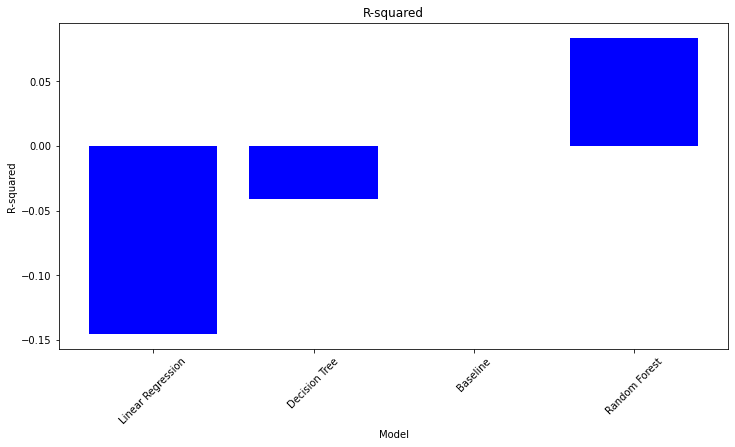

In [136]:
model_comparison(model_performance_dict, sort_by = 'R-squared', metric = 'R-squared')

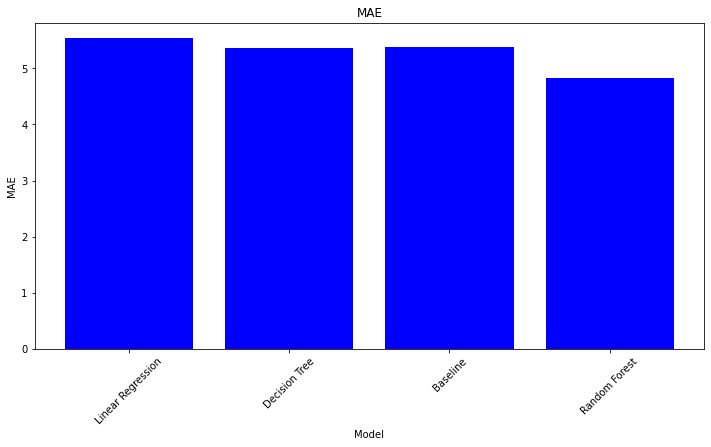

In [137]:
model_comparison(model_performance_dict, sort_by = 'R-squared', metric = 'MAE')

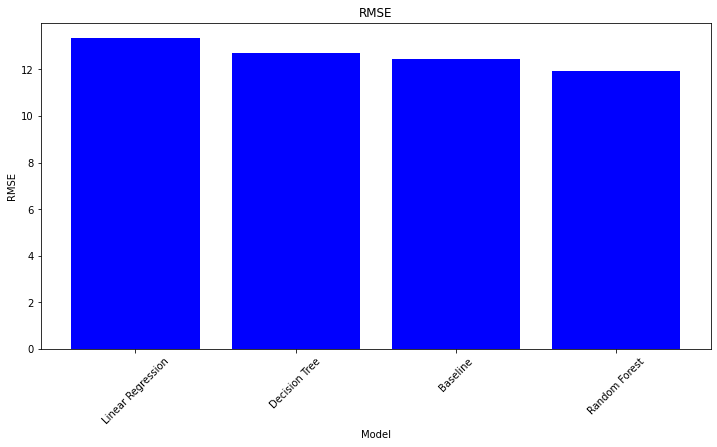

In [138]:
model_comparison(model_performance_dict, sort_by = 'R-squared', metric = 'RMSE')

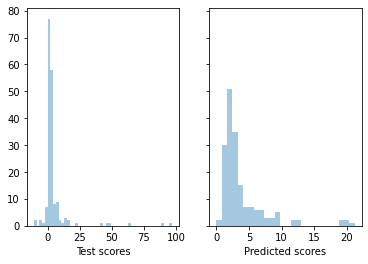

TypeError: ignored

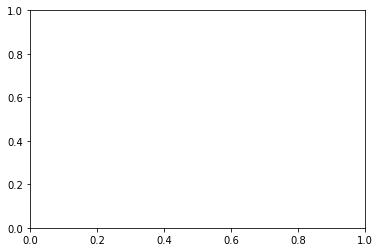

In [139]:
y_predicted = rf.predict(X_test)
plot_residuals(y_test,y_predicted)

In [141]:
rf_importances = get_feature_importance(rf)

subreddit_1911                : 29.92%

Total importance: 100.00%
word_counts                   : 23.05%

Total importance: 100.00%
senti_neu                     : 11.71%

Total importance: 100.00%
subreddit_30ROCK              :  6.26%

Total importance: 100.00%
subreddit_1200isplenty        :  5.13%

Total importance: 100.00%
parent_score                  :  3.46%

Total importance: 100.00%
comment_tree_root_score       :  3.26%

Total importance: 100.00%
subreddit_24hoursofuhc        :  3.02%

Total importance: 100.00%
subreddit_121stSquadron       :  2.97%

Total importance: 100.00%
senti_pos                     :  2.48%

Total importance: 100.00%
senti_comp                    :  2.19%

Total importance: 100.00%
subjectivity                  :  2.06%

Total importance: 100.00%
senti_neg                     :  1.36%

Total importance: 100.00%
time_since_parent             :  0.89%

Total importance: 100.00%
depth                         :  0.64%

Total importance: 100.00%
time_since